In [75]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline
pd.set_option('display.max_colwidth', None)

In [94]:
train_set=pd.read_csv("train_setpreproc.csv")
test_set=pd.read_csv("test_setpreproc.csv")
target_train=pd.read_csv("target_train.csv")
target_test=pd.read_csv("target_test.csv")
target_test=target_test['Class']
target_train=target_train['Class']

Models considered: <br>
I consider the following classifiers: RandomForest, LogisticRegression, Kernel SVM with rbf kernel . <br>
The evaluation metric I choose is average precision since the data is unbalanced and I assume that the class ratio won't change over time. AP is the area under precision-recall curve approximated with rectangle method: <br>
$AP:=\sum_{n=1}^{N} (R_{n}-R_{n-1})P_{n}$, where $(R_n,P_n)$ stands for recall and precision corresponding to threshold n given a set of $N+1$ theresholds. <br>
For each of the models above hyperparameters are tuned on train_set with a grid search cross validation (5 folds). Then each model is trained on train_set using the resulting best combination of parameters and finally I evaluate the performance of the models on test data and I choose the model with the highest AP score. Average precision on test data will be the final estimate of the model performance for the best model trained on the whole data.


In [95]:
def train_and_tune_hyp(model, parameter_grid, train_set, target):
    """The function performs a GridSearchCV for the given model and test the parametrs contained in parameter_grid.
    Parameters
    ------------
        model: sklearn model
                model whose hyperparameters must be tuned.
        parameter_grid: dict, 
              gird of parametrst for tuning
        train_set: pd.DataFrame,
                   training data
        target: pd.Series,
                target variable
    Return
    -----------
        grid_resf : pd.DataFrame
            DataFrame containing results of GridSearch for the given model and parameter grid.
        clf.best_params_: dict,
            best combination of parametrs accoridng to the chosen scoring rule
    It returns a DataFrame containing the results for each fold and each combination of parameters """
    cv_ = StratifiedKFold(n_splits=5, shuffle=True) #Stratification ensures that each fold has the same ratio between the two classes.
    clf = GridSearchCV(estimator=model, param_grid=parameter_grid, cv=cv_, scoring='average_precision',  return_train_score=True, error_score='raise')
    clf.fit(train_set,target)
    print('Best score: {}'.format(clf.best_score_))
    print('Best parameters: {}'.format(clf.best_params_))
    grid_resf = pd.DataFrame(clf.cv_results_)
    return grid_resf, clf.best_params_

The classes, $0$ and $1$, are not equally represented, therefore I weight them in the loss function to ensure that the model will be able to correctly predict the minority class as well. <br>
I consider balanced weights: <br>
$weight_i:=\frac{\lvert train_{set} \rvert}{\lvert \{0,1\}\rvert * \lvert \{x\in train_{set}| Class(x)=i\}\rvert}, \ i\in{0,1}$, <br>
where $x\in train_{set}$ is a training instance, i.e a row of train_set. <br>
Then I consider other weights: {0:1,1:2}, {0:1,1:3.5}. 


In [122]:
from sklearn import utils
print("Balnced weights for classes 0 and 1 in training set:", utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(target_train),y=target_train))

Balnced weights for classes 0 and 1 in training set: [0.61842105 2.61111111]


# Hyperparameters tuning with  Grid Search CV

In [96]:
models=[RandomForestClassifier(), LogisticRegression( max_iter=10000, solver='liblinear',penalty='l2'), SVC(probability=True)]  #SVC's kernel is rbf
parameter_grids=[{ 
    'n_estimators': [50,100,200,300,500],   
    'max_depth' : [5,10,16, None], 
    'max_features': ['log2','sqrt'],
    'min_samples_leaf': [1,2,5,10],
    'class_weight': ['balanced', {0:1, 1:3.5}, {0:1,1:2}, 'balanced_subsample']
   
}, {'C':[1.0,10,0.1,100, 0.001, 0.0001,1000], 'class_weight': ['balanced', {0:1, 1:3.5}, {0:1,1:2}]},
{'C': [1,0.1, 0.001, 0.0001, 10, 100, 1000], 'gamma': ['scale',1.e-01, 1.e-02, 1.e+00, 1.e+02], 'class_weight': ['balanced', {0:1, 1:3.5} , {0:1,1:2}]}
]#C for logistic regression and svm is the inverse of the regularization parameter
grid_search_res=[]
for i in range(len(models)):
    print("Model: ", models[i])
    grid_search_resf, best_params=train_and_tune_hyp(models[i], parameter_grids[i], train_set, target_train)
    grid_search_res.append([models[i], best_params, grid_search_resf])

Model:  RandomForestClassifier()
Best score: 0.8969989740344143
Best parameters: {'class_weight': {0: 1, 1: 2}, 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 200}
Model:  LogisticRegression(max_iter=10000, solver='liblinear')
Best score: 0.8070562219862343
Best parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 3.5}}
Model:  SVC(probability=True)
Best score: 0.8684803262006705
Best parameters: {'C': 1, 'class_weight': {0: 1, 1: 2}, 'gamma': 0.01}


In [97]:
cols=['Model','params','mean_test_score', 'std_test_score']#,'mean_train_score'] #columns of interest

In [129]:
#Extracting best combination of parameters for each of the considered models:
for g in grid_search_res:
    g[2]['Model']=str(g[0])
final_best_params=grid_search_res[0][2][cols][grid_search_res[0][2]['params']==grid_search_res[0][1]].copy()
for i in range(1,3):
    final_best_params=pd.concat([final_best_params,grid_search_res[i][2][cols][grid_search_res[i][2]['params']==grid_search_res[i][1]]])
final_best_params.Model=['rfc','lrc','svc']

# Best combination of parameters for each model

In [138]:
print("Final best parameters:")
final_best_params

Final best parameters:


,Model,params,mean_test_score,std_test_score
402,rfc,"{'class_weight': {0: 1, 1: 2}, 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 200}",0.896999,0.008625
7,lrc,"{'C': 0.1, 'class_weight': {0: 1, 1: 3.5}}",0.807056,0.044308
12,svc,"{'C': 1, 'class_weight': {0: 1, 1: 2}, 'gamma': 0.01}",0.868480,0.045780


# Evaluation on test data:

For each of the models, in addition to AP score, I will print the confusion matrix (threshold: 0.5) just to visualize the predictions

RANDOM FOREST

In [157]:
final_best_params.params.iloc[0]

{'class_weight': {0: 1, 1: 2},
 'max_depth': 16,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'n_estimators': 200}

In [158]:
#Random forest
rfc=RandomForestClassifier(class_weight= {0: 1, 1: 2},max_depth=16,max_features='log2',min_samples_leaf=1,n_estimators=200)
rfc.fit(train_set, target_train)
target_predtr=rfc.predict(train_set)
pred_probtr = rfc.predict_proba(train_set)
target_predts=rfc.predict(test_set)
pred_probte = rfc.predict_proba(test_set)
APtest_rfc=metrics.average_precision_score(target_test,pred_probte[:,1])
APtrain_rfc=metrics.average_precision_score(target_train,pred_probtr[:,1])
print("Train score AP: ", APtrain_rfc)
print("Test score AP: ",APtest_rfc)

Train score AP:  1.0
Test score AP:  0.85471025223371


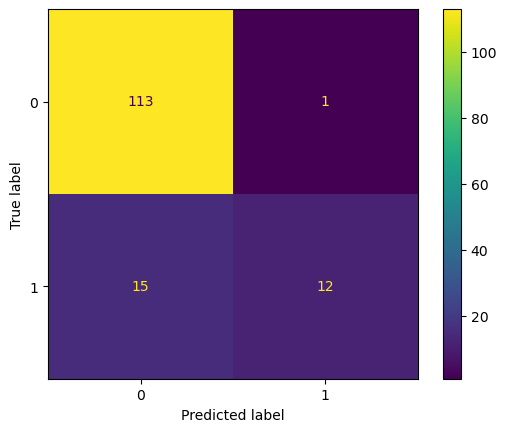

In [142]:
metrics.ConfusionMatrixDisplay.from_estimator(rfc, test_set,target_test);

LOGISTIC REGRESSION

In [144]:
final_best_params.params.iloc[1]

{'C': 0.1, 'class_weight': {0: 1, 1: 3.5}}

In [145]:
lrc=LogisticRegression(class_weight={0: 1, 1: 3.5},C=0.1, max_iter=10000, solver='liblinear', penalty='l2')
lrc.fit(train_set, target_train)
target_predtr=lrc.predict(train_set)
target_predts=lrc.predict(test_set)
pred_probte = lrc.predict_proba(test_set)
pred_probtr = lrc.predict_proba(train_set)
APtest_lrc=metrics.average_precision_score(target_test,pred_probte[:,1])
APtrain_lrc=metrics.average_precision_score(target_train,pred_probtr[:,1])
print("Train score AP: ", APtrain_lrc)
print("Test score AP: ",APtest_lrc)

Train score AP:  0.9158416908349728
Test score AP:  0.8436393768081938


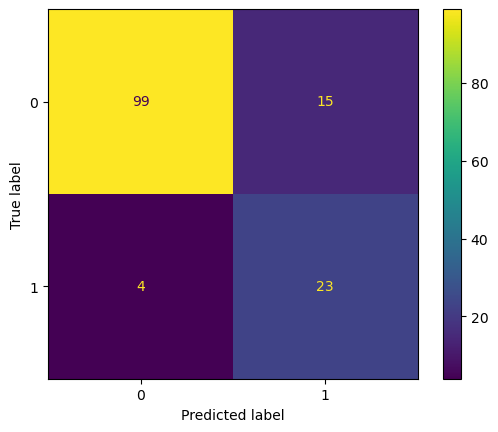

In [147]:
metrics.ConfusionMatrixDisplay.from_estimator(lrc, test_set,target_test);

SVC

In [148]:
final_best_params.params.iloc[2]

{'C': 1, 'class_weight': {0: 1, 1: 2}, 'gamma': 0.01}

In [154]:
svc=SVC(class_weight={0: 1, 1: 2},probability=True, gamma=0.01,C=1)
svc.fit(train_set, target_train)
target_predtr=svc.predict(train_set)
pred_probtr = svc.predict_proba(train_set)
target_predts=svc.predict(test_set)
pred_probte = svc.predict_proba(test_set)
APtest_svc=metrics.average_precision_score(target_test,pred_probte[:,1])
APtrain_svc=metrics.average_precision_score(target_train,pred_probtr[:,1])
print("Train score AP: ", APtrain_svc)
print("Test score AP: ",APtest_svc)

Train score AP:  0.9748387661937148
Test score AP:  0.9171130571318893


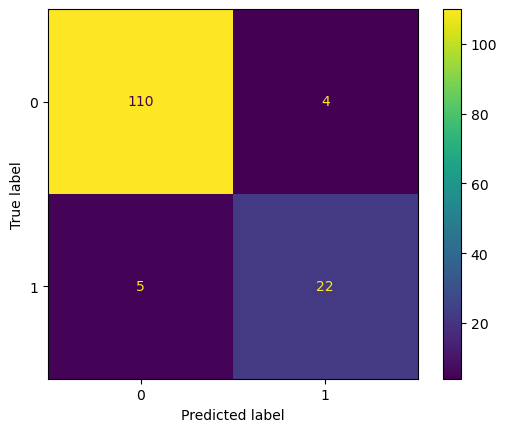

In [150]:
metrics.ConfusionMatrixDisplay.from_estimator(svc, test_set,target_test); #here threshold is 0.5

# Final results- Evaluation on test data

In [151]:
final_results_eval=pd.DataFrame({'Model':[str(rfc),str(lrc),str(svc)], 'AP train': [APtrain_rfc, APtrain_lrc, APtrain_svc], 'AP test': [APtest_rfc, APtest_lrc, APtest_svc]})

In [153]:
final_results_eval

,Model,AP train,AP test
0,"RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=16,\n max_features='log2', n_estimators=200)",1.000000,0.856070
1,"LogisticRegression(C=0.1, class_weight={0: 1, 1: 3.5}, max_iter=10000,\n solver='liblinear')",0.915842,0.843639
2,"SVC(C=1, class_weight={0: 1, 1: 2}, gamma=0.01, probability=True)",0.974839,0.917113


Plotting the preciosn-recall curves for each of the final models:

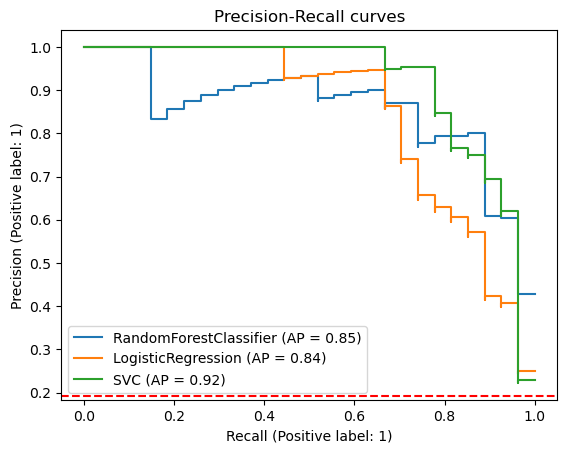

In [159]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots()
for model in [rfc,lrc,svc]:
        PrecisionRecallDisplay.from_estimator(model, test_set, target_test, ax=ax)
plt.axhline(y=target_test.sum() / len(target_test), color='red', linestyle='--', label='Random Guessing')
ax.set_title('Precision-Recall curves');
plt.show();

The best model is the SVC

Comparison with baseline model (same kernel function and defualt parameters):

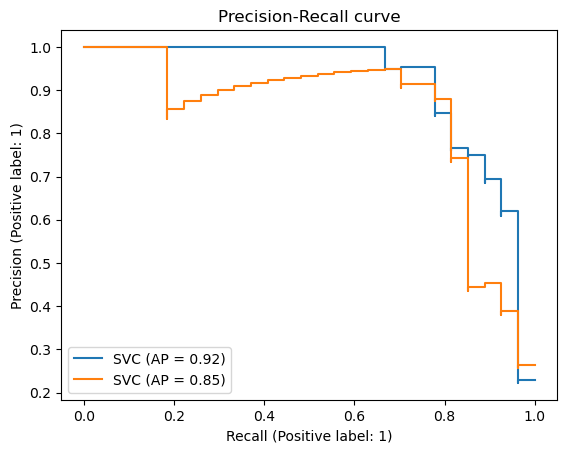

In [161]:
baseline_model=SVC(probability=True)
baseline_model.fit(train_set,target_train)
fig, ax = plt.subplots()
for model in [svc, baseline_model]:
                 PrecisionRecallDisplay.from_estimator(model, test_set, target_test, ax=ax)
   
ax.set_title('Precision-Recall curve');
plt.show();

# Final model

Final model: SVC(class_weight={0: 1, 1: 2},probability=True, gamma=0.01,C=1) trained on the whole data (preprocessed as above: missing values+ log + StandardScaler() for approx gaussian features) with average precision estimate AP computed on test data (0.92).